In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import random

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [ ]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)
  return score

In [7]:
def BO(model,kernel):
  optimizer = GPyOpt.methods.BayesianOptimization(f=model, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )
  optimizer.run_optimization(max_iter=20)

  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
          -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25))) - np.pi * 0.5 * np.log(2*np.pi)
  return log_mll

In [8]:
v1 = np.linspace(0.5,1.5,101)
l1 = np.linspace(0.1,3.0,101)
v2 = np.linspace(0.5,1.5,101)
l2 = np.linspace(0.1,3.0,101)

In [ ]:
score_rf=[]
v1_list=[]
l1_list=[]
v2_list=[]
l2_list=[]

for i in range(30):
  v1_=random.choice(v1)
  v1_list.append(v1_)
  l1_=random.choice(l1)
  l1_list.append(l1_)
  v2_=random.choice(v2)
  v2_list.append(v2_)
  l2_=random.choice(l2)
  l2_list.append(l2_)

  kernel1 = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3
  mll = BO(rf_score,kernel)
  score_rf.append(mll)

  print("v1 =", v1_, "l1 =", l1_, "v2 =", v2_, "l2 =", l2_, "mll =", mll)

v1 = 1.27 l1 = 1.3900000000000001 v2 = 1.44 l2 = 0.8200000000000001 mll = [[11.64043728]]
v1 = 0.87 l1 = 0.62 v2 = 0.6799999999999999 l2 = 1.3399999999999999 mll = [[3.54728323]]
v1 = 0.62 l1 = 1.4500000000000002 v2 = 0.73 l2 = 1.23 mll = [[3.02665051]]
v1 = 1.1 l1 = 1.0 v2 = 1.21 l2 = 0.6 mll = [[10.97874664]]
v1 = 1.27 l1 = 0.98 v2 = 1.21 l2 = 0.78 mll = [[19.38325669]]
v1 = 1.38 l1 = 1.03 v2 = 0.55 l2 = 1.06 mll = [[55.79627004]]
v1 = 1.27 l1 = 0.87 v2 = 1.02 l2 = 1.06 mll = [[32.7634212]]
v1 = 0.62 l1 = 1.19 v2 = 1.49 l2 = 1.03 mll = [[14.2548648]]
v1 = 0.59 l1 = 1.26 v2 = 1.0 l2 = 1.44 mll = [[2.53304514]]
v1 = 0.55 l1 = 0.81 v2 = 0.61 l2 = 0.55 mll = [[5.47411696]]
v1 = 1.22 l1 = 0.67 v2 = 0.96 l2 = 1.47 mll = [[45.72970394]]
v1 = 1.35 l1 = 0.54 v2 = 1.1 l2 = 0.64 mll = [[38.98716722]]
v1 = 0.6799999999999999 l1 = 0.88 v2 = 0.8400000000000001 l2 = 0.8 mll = [[2.37304338]]
v1 = 1.47 l1 = 1.13 v2 = 0.79 l2 = 0.86 mll = [[-4.05377273]]
v1 = 0.71 l1 = 0.97 v2 = 1.35 l2 = 0.61 mll = [

In [ ]:
kernel1 = GPy.kern.Matern52(input_dim=1,variance=1.38,lengthscale=1.03,active_dims=[0])
kernel2 = GPy.kern.Matern52(input_dim=1,variance=0.55,lengthscale=1.06,active_dims=[1])
kernel3 = GPy.kern.Matern52(input_dim=1,variance=1.38,lengthscale=1.03,active_dims=[0]) \
         * GPy.kern.Matern52(input_dim=1,variance=0.55,lengthscale=1.06,active_dims=[1])
kernel = kernel1 + kernel2 + kernel3

In [ ]:
for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)

  kernel1 = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0])
  kernel2 = GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  kernel3 = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  kernel = kernel1 + kernel2 + kernel3
  mll = BO(rf_score,kernel)
  print("l1 =", l1_, "l2 =", l2_, "mll =", mll)

l1 = 2.072 l2 = 2.913 mll = [[-5.4090463]]
l1 = 1.753 l2 = 0.7669999999999999 mll = [[-0.49356598]]
l1 = 0.361 l2 = 1.057 mll = [[3.80974492]]
l1 = 1.173 l2 = 1.579 mll = [[16.33640354]]
l1 = 0.477 l2 = 2.449 mll = [[1.71432653]]
l1 = 1.811 l2 = 2.7969999999999997 mll = [[0.84616946]]
l1 = 1.724 l2 = 2.072 mll = [[54.97415783]]
l1 = 2.507 l2 = 0.477 mll = [[11.96018802]]
l1 = 2.565 l2 = 2.594 mll = [[37.26561077]]
l1 = 1.463 l2 = 1.26 mll = [[2.86872855]]
l1 = 1.26 l2 = 1.55 mll = [[24.34740288]]
l1 = 2.014 l2 = 1.9849999999999999 mll = [[27.86286008]]
l1 = 2.507 l2 = 2.304 mll = [[59.75321257]]
l1 = 1.724 l2 = 1.9849999999999999 mll = [[10.61102236]]
l1 = 2.7969999999999997 l2 = 2.681 mll = [[0.13844341]]
l1 = 0.9699999999999999 l2 = 0.129 mll = [[44.03325657]]
l1 = 2.71 l2 = 0.129 mll = [[1.16476191]]
l1 = 2.6519999999999997 l2 = 2.217 mll = [[-4.47027069]]
l1 = 2.014 l2 = 0.245 mll = [[5.73547299]]
l1 = 2.536 l2 = 1.115 mll = [[-14.28301788]]
l1 = 2.304 l2 = 0.361 mll = [[63.4579972

In [ ]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.001, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)

  return score

In [ ]:
for i in range(30):
  v1_=random.choice(v1)
  l1_=random.choice(l1)
  v2_=random.choice(v2)
  l2_=random.choice(l2)

  kernel = GPy.kern.Matern52(input_dim=1,variance=v1_,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,variance=v2_,lengthscale=l2_,active_dims=[1])
  mll = BO(svm_score,kernel)
  print("v1 =", v1_, "l1 =", l1_, "v2 =", v2_, "l2 =", l2_, "mll =", mll)

v1 = 1.35 l1 = 1.3599999999999999 v2 = 0.76 l2 = 1.31 mll = [[-6.03156147]]
v1 = 1.3399999999999999 l1 = 1.48 v2 = 1.4500000000000002 l2 = 1.4 mll = [[-11.0535599]]
v1 = 1.0 l1 = 0.52 v2 = 0.66 l2 = 0.64 mll = [[-11.51976621]]
v1 = 1.3 l1 = 1.33 v2 = 1.1099999999999999 l2 = 0.75 mll = [[2.55729217]]
v1 = 1.27 l1 = 0.78 v2 = 0.5700000000000001 l2 = 0.55 mll = [[-14.10267993]]
v1 = 0.51 l1 = 0.6799999999999999 v2 = 0.73 l2 = 0.81 mll = [[-16.03073265]]
v1 = 0.56 l1 = 0.77 v2 = 0.95 l2 = 1.3900000000000001 mll = [[-7.05446438]]
v1 = 1.17 l1 = 1.04 v2 = 0.98 l2 = 1.3399999999999999 mll = [[-6.97891284]]
v1 = 0.95 l1 = 1.21 v2 = 1.23 l2 = 1.08 mll = [[-8.57886439]]
v1 = 1.47 l1 = 1.0899999999999999 v2 = 1.02 l2 = 1.48 mll = [[-16.305148]]
v1 = 1.27 l1 = 1.0 v2 = 0.8200000000000001 l2 = 0.58 mll = [[-17.85148275]]
v1 = 0.8400000000000001 l1 = 0.9299999999999999 v2 = 0.51 l2 = 1.28 mll = [[-13.76641205]]
v1 = 1.47 l1 = 0.73 v2 = 1.22 l2 = 1.24 mll = [[-14.95758332]]
v1 = 1.02 l1 = 0.75 v2 = 0

In [ ]:
kernel = GPy.kern.Matern52(input_dim=1,variance=1.13,lengthscale=0.92,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=0.66,lengthscale=1.38,active_dims=[1])

In [ ]:
for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)

  kernel = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  mll = BO(svm_score,kernel)
  print("l1 =", l1_, "l2 =", l2_, "mll =", mll)

l1 = 1.173 l2 = 0.5349999999999999 mll = [[105.98533971]]
l1 = 0.825 l2 = 0.39 mll = [[105.98530353]]
l1 = 1.347 l2 = 1.1440000000000001 mll = [[105.98573364]]
l1 = 2.565 l2 = 2.913 mll = [[105.98562079]]
l1 = 1.231 l2 = 1.898 mll = [[105.98544115]]
l1 = 1.9849999999999999 l2 = 0.303 mll = [[105.98553605]]
l1 = 2.855 l2 = 1.956 mll = [[105.98576097]]
l1 = 1.434 l2 = 1.956 mll = [[105.98549766]]
l1 = 1.956 l2 = 1.724 mll = [[105.98506476]]
l1 = 0.5349999999999999 l2 = 1.753 mll = [[105.98557098]]
l1 = 0.7379999999999999 l2 = 2.391 mll = [[105.98640204]]
l1 = 0.361 l2 = 0.303 mll = [[105.98498948]]
l1 = 2.4779999999999998 l2 = 1.1440000000000001 mll = [[105.98433634]]
l1 = 0.825 l2 = 1.028 mll = [[105.98521208]]
l1 = 0.1 l2 = 2.6519999999999997 mll = [[105.98542047]]
l1 = 2.246 l2 = 0.5349999999999999 mll = [[105.98535659]]
l1 = 1.347 l2 = 0.44799999999999995 mll = [[105.98558035]]
l1 = 1.376 l2 = 2.391 mll = [[105.98544932]]
l1 = 2.7969999999999997 l2 = 1.434 mll = [[105.98579738]]
l1 =

In [13]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (1, 100)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]


def knn_score(parameters):
  params = {
        'leaf_size': int(parameters[0][0]),
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)

  return score

{'covariance': [[<matplotlib.lines.Line2D at 0x7f259b889130>]]}

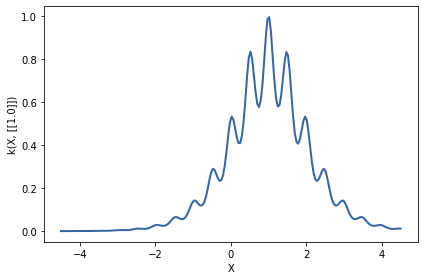

In [25]:
kernel = GPy.kern.StdPeriodic(input_dim=1,period=0.5) * GPy.kern.Matern52(input_dim=1)
kernel.plot()

In [22]:
l3 = np.linspace(0.1,3.0,101)
for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)
  l3_=random.choice(l3)
  kernel1 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=l1_,active_dims=[0],period=13) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[0])
  kernel2 = GPy.kern.StdPeriodic(input_dim=1,lengthscale=l3_,active_dims=[1],period=2)
  kernel = kernel1 + kernel2
  mll = BO(knn_score,kernel)
  print("l1 =", l1_, "l2 =", l2_, "l3 = ", l3_, "mll =", mll)

l1 = 0.129 l2 = 0.506 l3 =  1.115 mll = [[11.26468692]]
l1 = 0.6799999999999999 l2 = 2.4779999999999998 l3 =  1.782 mll = [[20.39480675]]
l1 = 1.173 l2 = 0.41899999999999993 l3 =  2.7969999999999997 mll = [[4.22959688]]
l1 = 1.782 l2 = 0.506 l3 =  1.579 mll = [[46.72121967]]
l1 = 1.695 l2 = 2.565 l3 =  0.593 mll = [[31.04956417]]
l1 = 1.521 l2 = 2.3329999999999997 l3 =  1.318 mll = [[25.44158669]]
l1 = 1.434 l2 = 2.6519999999999997 l3 =  1.608 mll = [[28.28499611]]
l1 = 2.594 l2 = 1.434 l3 =  2.217 mll = [[34.72167654]]
l1 = 1.811 l2 = 1.9849999999999999 l3 =  2.217 mll = [[36.29323343]]
l1 = 0.7959999999999999 l2 = 0.33199999999999996 l3 =  2.4779999999999998 mll = [[25.00109381]]
l1 = 1.26 l2 = 0.1 l3 =  1.55 mll = [[26.51873874]]
l1 = 1.521 l2 = 2.014 l3 =  1.956 mll = [[60.72237596]]
l1 = 2.6229999999999998 l2 = 2.6229999999999998 l3 =  3.0 mll = [[37.7647732]]
l1 = 0.564 l2 = 1.608 l3 =  1.666 mll = [[38.09984619]]
l1 = 2.507 l2 = 0.39 l3 =  2.768 mll = [[7.34025831]]
l1 = 0.76699